<a href="https://colab.research.google.com/github/RReed637/Suicide-Risk/blob/main/Notebook/SuicideWatchRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyprind
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install plotly
!pip install plotly.io
!pip install plotly.express
!pip install tensorflow
!pip install keras
!pip install sklearn
!pip install pandas
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


ERROR: Could not find a version that satisfies the requirement plotly.io (from versions: none)
ERROR: No matching distribution found for plotly.io
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 92.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0

In [2]:
import pandas as pd
import pyprind
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.io as pio


## RNN


#### Creating datasets

In [3]:

# Step 3: Define Custom Dataset Class
class CustomDataset():
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx, 0]  # Assuming text is in the first column
        label = self.dataframe.iloc[idx, 1]  # Assuming label is in the second column
        return text, label


In [4]:
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

train_on_gpu = True

# Load the CSV file into a DataFrame, specifying the delimiter
df = pd.read_csv(r'/content/cleaned_data.csv', delimiter=',', header=None)  # Assuming no header

df = df.reset_index(drop=True)
# Rename the class column to "label"
df = df.rename(columns={0: 'text', 1: 'label'})
df = df.drop(0)
print(df.head())

# Split the data into train, validation, and test sets
train_valid_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, valid_df = train_test_split(train_valid_df, test_size=0.25, random_state=42)  # Splitting 80% for train and 20% for validation

# Process tokens to remove extra characters (such as commas, single quotes, and square brackets)
def preprocess_tokens(sentence):
    return [word.strip(",'[]") for word in sentence.split()]

# Create a counter to count word frequencies
word_counter = Counter()

# Count word frequencies from the training data
for sentence in train_df['text']:
    word_counter.update(preprocess_tokens(sentence))

# Create a vocabulary ordered by word frequency
vocab_ordered = {'<pad>': 0, '<unk>': 1}
word_index = len(vocab_ordered)
for word, count in word_counter.most_common():
    vocab_ordered[word] = word_index
    word_index += 1

# Optionally, you can save the vocab to a file for later use
with open('vocab_ordered.txt', 'w') as f:
    for word, index in vocab_ordered.items():
        f.write(f"{word}: {index}\n")

# Now you have train_df, valid_df, test_df DataFrames with the label column renamed
# You can proceed with tokenization, building vocabulary, and encoding labels as needed


<ipython-input-4-e8346e63ea1d>:8: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'/content/cleaned_data.csv', delimiter=',', header=None)  # Assuming no header


                                                text label    2    3    4  \
1  ['someone', 'explain', 'attract', 'boy', 'gay'...     0  NaN  NaN  NaN   
2  ['voluntary', 'admission', 'hospital', 'suicid...     1  NaN  NaN  NaN   
3  ['want', 'end', 'life', 'scare', 'consequence'...     1  NaN  NaN  NaN   
4  ['still', 'think', 'I', 'last', 'year', 'swear...     0  NaN  NaN  NaN   
5  ['aware', 'one', 'care', 'want', 'girl', 'woul...     0  NaN  NaN  NaN   

     5    6    7    8    9  ...  100  101  102  103  104  105  106  107  108  \
1  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
5  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

  109  
1 NaN  
2 NaN  
3 NaN  
4 NaN  
5 NaN  

[5 rows

# THIS IS THE PROBLEM!!!

# TASKS FOR Today:
### Build 3 RNN Models using these three types of recurrent layers
#### RNN
#### LSTM
#### GRU


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn

# Define text and label pipelines
text_pipeline = lambda x: [vocab_ordered[word] if word in vocab_ordered else vocab_ordered['<unk>'] for word in preprocess_tokens(x)]
label_pipeline = lambda x: torch.tensor([int(x), 1 - int(x)], dtype=torch.float32)


def collate_batch(batch):
    text_list, label_list = [], []
    for text, label in batch:
        label_list.append(label_pipeline(label))
        processed_text = torch.tensor(text_pipeline(text), dtype=torch.int64)
        text_list.append(processed_text)

    label_list = torch.stack(label_list, dim = 0)

    padded_text_list = nn.utils.rnn.pad_sequence(text_list, batch_first=True, padding_value=0)

    # Create a dictionary containing the processed text, labels, and lengths
    batch_dict = {
        'text': padded_text_list,
        'label': label_list
    }

    return batch_dict

# Assuming you have already defined your training, validation, and test DataFrames as train_df, valid_df, and test_df respectively

# Instantiate CustomDataset objects
train_dataset = CustomDataset(train_df)
valid_dataset = CustomDataset(valid_df)
test_dataset = CustomDataset(test_df)

# Define batch size
batch_size = 32

# Create DataLoader objects for training, validation, and test sets
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_dl = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)




In [6]:
# Check batch sizes of DataLoader objects
def check_batch_sizes(dataloader):
    batch_sizes = []
    for batch in dataloader:
        batch_sizes.append(batch['text'].shape[0])# Get batch size from the 'text' tensor
        x = batch_sizes
    return x



In [7]:
for batch in train_dl:
    print(batch['text'].dtype)
    print(batch['label'].dtype)
    break
      # Only print the structure of the first batch

torch.int64
torch.float32


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim





class LSTMModel(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim


        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=0)


        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                           batch_first=True)  # LSTM layer
        self.dropout = nn.Dropout(dropout)
        self.global_max_pooling = nn.AdaptiveMaxPool1d(1)  # Global max pooling

        self.fc = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embedded = self.embedding(x)
        lstm_output, hidden = self.lstm(embedded)
        lstm_output = self.dropout(lstm_output)
        out = self.fc(lstm_output[:, -1])  # Apply linear layer to last output
        output = torch.sigmoid(out)  # Apply sigmoid activation
        return output, hidden



    def init_hidden(self, batch_size):
      '''Initialize Hidden State'''
      weight = next(self.parameters()).data

      hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

      if torch.cuda.is_available():
          hidden = (hidden[0].cuda(), hidden[1].cuda())

      return hidden




In [9]:

from torch.optim.lr_scheduler import ReduceLROnPlateau
vocab_size = len(vocab_ordered)+1
output_size = 2
embedding_dim = 32
hidden_dim = 64
n_layers = 2

# Define your model, loss function, and optimizer
net = LSTMModel(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Define a learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

Epoch: 1/15... Loss: 0.399663... Val Loss: 0.235129 Train Accuracy: 0.791561 Val Accuracy: 0.911049 Training Precision: 0.8046 Training Recall: 0.8091 Training F1 Score: 0.8068 Training ROC AUC Score: 0.8063 Validation Precision: 0.9114 Validation Recall: 0.9150 Validation F1 Score: 0.9132 Validation ROC AUC Score: 0.9130
Epoch: 2/15... Loss: 0.213282... Val Loss: 0.195798 Train Accuracy: 0.920334 Val Accuracy: 0.925725 Training Precision: 0.9211 Training Recall: 0.9206 Training F1 Score: 0.9209 Training ROC AUC Score: 0.9209 Validation Precision: 0.9261 Validation Recall: 0.9259 Validation F1 Score: 0.9258 Validation ROC AUC Score: 0.9258
Epoch: 3/15... Loss: 0.181564... Val Loss: 0.185678 Train Accuracy: 0.932735 Val Accuracy: 0.929484 Training Precision: 0.9329 Training Recall: 0.9330 Training F1 Score: 0.9330 Training ROC AUC Score: 0.9329 Validation Precision: 0.9297 Validation Recall: 0.9296 Validation F1 Score: 0.9296 Validation ROC AUC Score: 0.9296
Epoch: 4/15... Loss: 0.16236

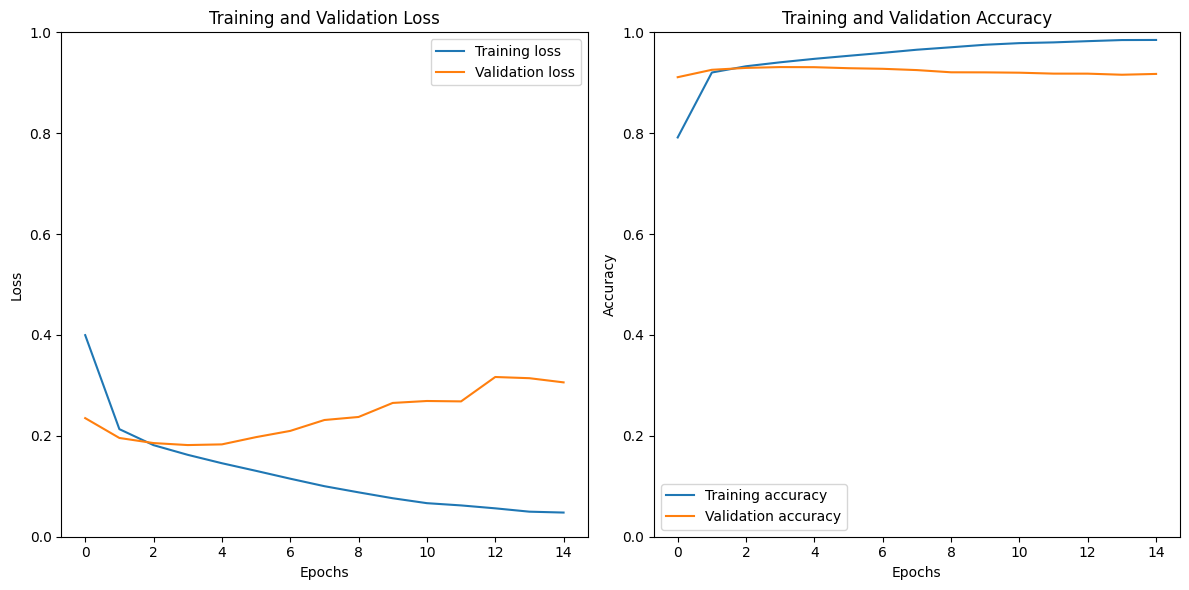

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def train():
    # Initialize lists to store evaluation metrics
    precision_scores_train = []
    recall_scores_train = []
    f1_scores_train = []
    roc_auc_scores_train = []

    precision_scores_val = []
    recall_scores_val = []
    f1_scores_val = []
    roc_auc_scores_val = []

    # training params
    epochs = 15
    print_every = 1000
    clip = 3  # gradient clipping

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # move model to GPU, if available
    if train_on_gpu:
        net.cuda()

    for e in range(epochs):
        net.train()

        true_labels_train_epoch = []
        predicted_labels_train_epoch = []
        epoch_train_losses = []

        # batch loop
        for batch in train_dl:
            text, labels = batch['text'], batch['label']

            if train_on_gpu:
                text, labels = text.cuda(), labels.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = net.init_hidden(batch_size)
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            net.zero_grad()

            # get the output from the model
            output, h = net(text, h)

            # calculate the loss and perform backprop
            loss = criterion(output.squeeze(), labels)
            loss.backward()

            gradients = []
            for param in net.parameters():
                gradients.append(param.grad.view(-1))
            all_gradients = torch.cat(gradients).cpu()

            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            optimizer.step()


            # Append true and predicted labels for training data
            true_labels_train_epoch.extend(labels.cpu().numpy())
            predicted_labels_train_epoch.extend(torch.round(output.squeeze()).detach().cpu().numpy())

            # Append loss for this step
            epoch_train_losses.append(loss.item())

        # Calculate average loss for the epoch
        epoch_train_loss = np.mean(epoch_train_losses)
        train_losses.append(epoch_train_loss)

        # Get validation loss
        net.eval()
        val_losses_epoch = []
        true_labels_val = []
        predicted_labels_val = []

        for val_batch in valid_dl:
            val_text, val_labels = val_batch['text'], val_batch['label']

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            val_h = net.init_hidden(batch_size)
            val_h = tuple([each.data for each in val_h])

            if train_on_gpu:
                val_text, val_labels = val_text.cuda(), val_labels.cuda()

            output, val_h = net(val_text, val_h)
            val_loss = criterion(output.squeeze(), val_labels)

            val_losses_epoch.append(val_loss.item())  # Append the validation loss

            # Append true and predicted labels for validation data
            true_labels_val.extend(val_labels.cpu().numpy())
            predicted_labels_val.extend(torch.round(output.squeeze()).detach().cpu().numpy())

        val_losses.append(np.mean(val_losses_epoch))

        # Calculate and append accuracies
        train_acc = accuracy_score(true_labels_train_epoch, predicted_labels_train_epoch)
        val_acc = accuracy_score(true_labels_val, predicted_labels_val)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Calculate and append evaluation metrics
        precision_scores_train.append(precision_score(true_labels_train_epoch, predicted_labels_train_epoch, average='macro'))
        recall_scores_train.append(recall_score(true_labels_train_epoch, predicted_labels_train_epoch, average='macro'))
        f1_scores_train.append(f1_score(true_labels_train_epoch, predicted_labels_train_epoch, average='macro'))
        roc_auc_scores_train.append(roc_auc_score(true_labels_train_epoch, predicted_labels_train_epoch))

        precision_scores_val.append(precision_score(true_labels_val, predicted_labels_val, average='macro'))
        recall_scores_val.append(recall_score(true_labels_val, predicted_labels_val, average='macro'))
        f1_scores_val.append(f1_score(true_labels_val, predicted_labels_val, average='macro'))
        roc_auc_scores_val.append(roc_auc_score(true_labels_val, predicted_labels_val))

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Loss: {:.6f}...".format(epoch_train_loss),
              "Val Loss: {:.6f}".format(np.mean(val_losses_epoch)),
              "Train Accuracy: {:.6f}".format(train_acc),
              "Val Accuracy: {:.6f}".format(val_acc),
              "Training Precision: {:.4f}".format(precision_scores_train[-1]),
              "Training Recall: {:.4f}".format(recall_scores_train[-1]),
              "Training F1 Score: {:.4f}".format(f1_scores_train[-1]),
              "Training ROC AUC Score: {:.4f}".format(roc_auc_scores_train[-1]),
              "Validation Precision: {:.4f}".format(precision_scores_val[-1]),
              "Validation Recall: {:.4f}".format(recall_scores_val[-1]),
              "Validation F1 Score: {:.4f}".format(f1_scores_val[-1]),
              "Validation ROC AUC Score: {:.4f}".format(roc_auc_scores_val[-1]))


    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot training and validation losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses,  label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 1)
    plt.legend()
    plt.title('Training and Validation Loss')

    # Plot training and validation accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training accuracy')
    plt.plot(val_accuracies, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

train()


In [11]:
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  28909 KiB |   1733 MiB |  16154 GiB |  16154 GiB |\n|       from large pool |  27993 KiB |   1732 MiB |  15795 GiB |  15795 GiB |\n|       from small pool |    916 KiB |      5 MiB |    358 GiB |    358 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         |  28909 KiB |   1733 MiB |  16154 GiB |  16154 GiB |\n|       from large pool |  27993 KiB |   1732 MiB |

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    # d_model must be divisable by the number of heads
    assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

    #Initialize Dimensions
    self.d_model = d_model #Model's Dimension
    self.num_heads = num_heads # Number of attention heads
    self.d_k = d_model // num_heads # Dimension of each head's key, query, and value

    # Linear Layers for transforming inputs

    self.W_q = nn.Linear(d_model, d_model)

class TransformerBlock(nn.Module):
  def __init__(self, embed_dim, num_heads, ff_dim, rate):
    super(TransformerBlock, self).__init__()
    self.att =



SyntaxError: invalid syntax (<ipython-input-12-f543cee718e4>, line 22)

In [ ]:

def train_model(dataloader):
    total_acc, total_loss = 0.0, 0.0
    for i, batch in enumerate(dataloader):
        print(f"Batch Index: {i}")
        text_batch = batch['text']
        label_batch = batch['label']
        lengths = batch['length']

        num_classes = 2  # Number of classes in your classification task
        label_batch_one_hot = torch.zeros(label_batch.size(0), num_classes, dtype=torch.float32)  # Initialize with float dtype
        label_batch_one_hot.scatter_(1, label_batch.unsqueeze(1).long(), 1)  # Convert label_batch to int64 using .long()

        h_prev = np.zeros((hidden_size, text_batch.shape[1]))  # Initialize hidden state
        print("Initial h_prev:", h_prev)
        loss = rnn_model.train_step(text_batch, label_batch, h_prev)
        print("Updated h_prev:", h_prev)

        total_loss += loss * text_batch.shape[1]

        pred = rnn_model.forward(text_batch, h_prev)[0]
        total_acc += ((pred >= 0.5).astype(float) == label_batch).astype(float).sum().item()

    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)

In [ ]:
def evaluate(dataloader):
    total_acc, total_loss = 0.0, 0.0
    for i, batch in enumerate(dataloader):
        print(f"Batch Index: {i}")
        text_batch = batch['text']
        label_batch = batch['label']
        lengths = batch['length']

        h_prev = np.zeros((hidden_size, text_batch.shape[1]))  # Initialize hidden state
     # Initialize hidden state

        loss = rnn_model.train_step(text_batch, label_batch, h_prev)

        total_loss += loss * text_batch.shape[0]

        pred = rnn_model.forward(text_batch, h_prev)[0]
        total_acc += ((pred >= 0.5).astype(float) == label_batch).astype(float).sum().item()

    return total_acc / len(dataloader.dataset), total_loss / len(dataloader.dataset)


In [ ]:

torch.manual_seed(1)
for epoch in range(num_epochs):
    acc_train, loss_train = train_model(train_dl)
